In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from numpy import log
from time import time
from datetime import timedelta
from datetime import datetime

In [85]:
df = pd.read_csv('BOPGSTB.csv', parse_dates=['DATE'], index_col = 'DATE')
df

,BOPGSTB
DATE,
1992-01-01,-2026.0
1992-02-01,-831.0
1992-03-01,-2641.0
1992-04-01,-3109.0
1992-05-01,-3919.0
...,...
2021-10-01,-66945.0
2021-11-01,-80068.0
2021-12-01,-81957.0


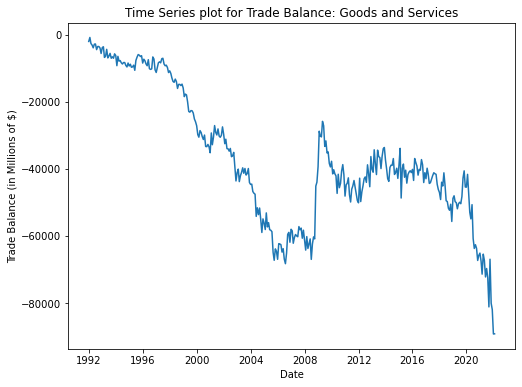

In [30]:
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(df.index, df['BOPGSTB'])
plt.title('Time Series plot for Trade Balance: Goods and Services', fontsize = 12)
plt.xlabel('Date')
plt.ylabel('Trade Balance (in Millions of $)')
plt.show()

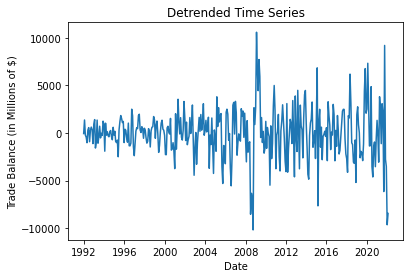

In [14]:
# Subtracting the Trend Component
result_mul = seasonal_decompose(df['BOPGSTB'], model = 'additive', extrapolate_trend = 'freq')
series = df.values.reshape(-1)
detrended = series - result_mul.trend.values
plt.plot(df.index, detrended)
plt.title('Detrended Time Series', fontsize = 12)
plt.xlabel('Date')
plt.ylabel('Trade Balance (in Millions of $)')
plt.show()

In [28]:
# # Subtracting the Seasonal Component
# deseasonalized = series / result_mul.seasonal.values
# plt.plot(deseasonalized)
# plt.title('Deseasonalized Time Series', fontsize=12)
# plt.xlabel('Date')
# plt.ylabel('Trade Balance (in Millions of $)')
# plt.show()

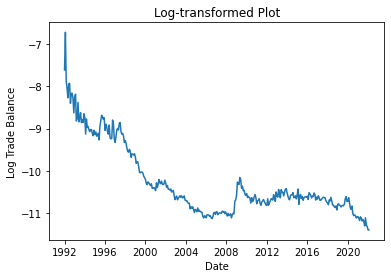

In [31]:
transform = log(series*-1)*-1

plt.plot(df.index, transform)
plt.title('Log-transformed Plot', fontsize = 12)
plt.xlabel('Date')
plt.ylabel('Log Trade Balance')
plt.show()

In [32]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

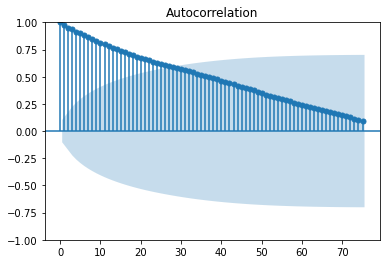

In [135]:
plot_acf(series, lags=75);

/Users/agam/miniforge3/envs/env_tf/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


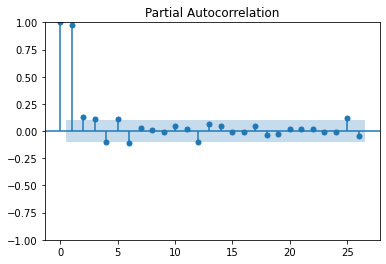

In [137]:
plot_pacf(series);

In [91]:
from statsmodels.tsa.arima.model import ARIMA

In [53]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [61]:
df_series = pd.read_csv('BOPGSTB.csv', parse_dates=['DATE'], index_col=None, date_parser=parser)
df_series

,DATE,BOPGSTB
0,1992-01-01,-2026.0
1,1992-02-01,-831.0
2,1992-03-01,-2641.0
3,1992-04-01,-3109.0
4,1992-05-01,-3919.0
...,...,...
357,2021-10-01,-66945.0
358,2021-11-01,-80068.0
359,2021-12-01,-81957.0
360,2022-01-01,-89229.0


In [94]:
# train_data['BOPGSTB']

0      -2026.0
1       -831.0
2      -2641.0
3      -3109.0
4      -3919.0
        ...   
345   -63678.0
346   -67307.0
347   -65802.0
348   -65124.0
349   -67548.0
Name: BOPGSTB, Length: 350, dtype: float64

In [76]:
# ?ARIMA

In [141]:
train_data = df_series[:-12].reset_index(drop=True)
test_data = df_series[-12:].reset_index(drop=True)

In [161]:
# 
model = ARIMA(train_data['BOPGSTB'], order=(4,1,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                BOPGSTB   No. Observations:                  350
Model:                 ARIMA(4, 1, 2)   Log Likelihood               -3262.096
Date:                Mon, 02 May 2022   AIC                           6538.191
Time:                        17:05:15   BIC                           6565.177
Sample:                             0   HQIC                          6548.934
                                - 350                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9292      0.231     -4.023      0.000      -1.382      -0.476
ar.L2          0.0183      0.279      0.066      0.948      -0.529       0.565
ar.L3          0.2493      0.100      2.495      0.0

/Users/agam/miniforge3/envs/env_tf/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/agam/miniforge3/envs/env_tf/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/agam/miniforge3/envs/env_tf/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [163]:
for i in range(4, 11):
    model = ARIMA(train_data['BOPGSTB'], order=(i,0,1))
    model_fit = model.fit()
    print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                BOPGSTB   No. Observations:                  350
Model:                 ARIMA(4, 0, 1)   Log Likelihood               -3274.385
Date:                Mon, 02 May 2022   AIC                           6562.769
Time:                        17:05:35   BIC                           6589.775
Sample:                             0   HQIC                          6573.518
                                - 350                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -3.56e+04   1.43e+04     -2.493      0.013   -6.36e+04   -7607.456
ar.L1          1.0155      0.222      4.572      0.000       0.580       1.451
ar.L2         -0.0449      0.176     -0.254      0.7

                               SARIMAX Results                                
Dep. Variable:                BOPGSTB   No. Observations:                  350
Model:                 ARIMA(8, 0, 1)   Log Likelihood               -3273.582
Date:                Mon, 02 May 2022   AIC                           6569.163
Time:                        17:05:36   BIC                           6611.601
Sample:                             0   HQIC                          6586.055
                                - 350                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -3.56e+04   1.49e+04     -2.382      0.017   -6.49e+04   -6302.299
ar.L1          0.3315      0.866      0.383      0.702      -1.365       2.028
ar.L2          0.4503      0.638      0.705      0.4

In [151]:
pred_start_date=test_data['DATE'][0]
pred_end_date=test_data['DATE'][11]

In [152]:
predictions = model_fit.predict(start = pred_start_date, end = pred_end_date)
residuals = test_data['BOPGSTB'] - predictions

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

In [189]:
from statsmodels.tsa.stattools import adfuller
# https://machinelearningmastery.com/time-series-data-stationary-python/
# X = df['BOPGSTB']
X = X.diff().dropna()
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.442180
p-value: 0.000000
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


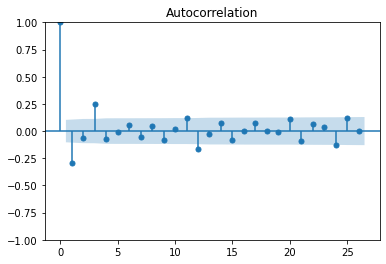

In [190]:
plot_acf(X.dropna());

In [183]:
model = ARIMA(train_data['BOPGSTB'], order=(3,1,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                BOPGSTB   No. Observations:                  350
Model:                 ARIMA(3, 1, 0)   Log Likelihood               -3263.659
Date:                Mon, 02 May 2022   AIC                           6535.319
Time:                        17:13:38   BIC                           6550.739
Sample:                             0   HQIC                          6541.457
                                - 350                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2511      0.041     -6.103      0.000      -0.332      -0.170
ar.L2         -0.1038      0.044     -2.340      0.019      -0.191      -0.017
ar.L3          0.2237      0.040      5.618      0.0

In [129]:
X.diff()

DATE
1992-01-01        NaN
1992-02-01     1195.0
1992-03-01    -1810.0
1992-04-01     -468.0
1992-05-01     -810.0
               ...   
2021-10-01    14214.0
2021-11-01   -13123.0
2021-12-01    -1889.0
2022-01-01    -7272.0
2022-02-01       44.0
Name: BOPGSTB, Length: 362, dtype: float64